In [2]:
#%% IMPORTS 

import mne
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [183]:

#%% PREPROCESSIN

def preprocess_sensor_space_data(subject, date, raw_path,
                                 event_id=dict(
                                            ipos = 21,
                                            ipos_wneu = 41,
                                            ineg = 22,
                                            ineg_wneu = 42,
                                            wpos = 11,
                                            wneg = 12,
                                            wneu = 13
                                            ),
                                 h_freq=40,
                                 tmin=-0.200, tmax=0.500, baseline=(None, 0),
                                 reject=None, decim=1,
                                 return_epochs=False,
                                 ):
    n_recordings = 6
    epochs_list = list()
    for recording_index in range(n_recordings): # ## loop from 0 to 5
        fif_index = recording_index + 1 # files are not 0-indexed
        fif_fname = 'face_word_' + str(fif_index) 
        if subject == '0085': ## sonething went wrong with the first three rec.
            folder_name = '00' + str(fif_index + 3) + '.' + fif_fname
        else:
            folder_name = '00' + str(fif_index) + '.' + fif_fname # HERE A CRUCIAL DOT WAS ADDED
            
        full_path = join(raw_path, subject, date, 'MEG', folder_name,
                         'files', fif_fname + '.fif')
        raw = mne.io.read_raw(full_path, preload=True)
        raw.filter(l_freq=None, h_freq=h_freq, n_jobs=4)
        
        events = mne.find_events(raw, min_duration=0.002)
        epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,
                            preload=True, decim=decim)
        epochs.pick_types(meg=True)
        if return_epochs:
            epochs_list.append(epochs)
        else:
            if recording_index == 0:
                X = epochs.get_data()
                y = epochs.events[:, 2]
            else:
                X = np.concatenate((X, epochs.get_data()), axis=0)
                y = np.concatenate((y, epochs.events[:, 2]))
    
    if return_epochs:
        return epochs_list
    else:
        return X, y

def preprocess_source_space_data(subject, date, raw_path, subjects_dir,
                                 epochs_list=None,
                              event_id=dict(ipos = 21,
                                            ipos_wneu = 41,
                                            ineg = 22,
                                            ineg_wneu = 42,
                                            wpos = 11,
                                            wneg = 12,
                                            wneu = 13
                                            ),
                              h_freq=40,
                              tmin=-0.200, tmax=0.500, baseline=(None, 0),
                              reject=None, decim=1,
                              method='MNE', lambda2=1, pick_ori='normal',
                              label= None): ####### HERE
    if epochs_list is None:
        epochs_list = preprocess_sensor_space_data(subject, date, raw_path,
                                                   return_epochs=True)
    y = np.zeros(0)
    for epochs in epochs_list: # get y
        y = np.concatenate((y, epochs.events[:, 2]))
    
    if label is not None:
        label_path = join(subjects_dir, subject, 'label', label)
        label = mne.read_label(label_path)
    
    for epochs_index, epochs in enumerate(epochs_list): ## get X
        fwd_fname = 'face_word_' + str(epochs_index + 1) + '-oct-6-src-' + \
                    '5120-5120-5120-fwd.fif'
        fwd = mne.read_forward_solution(join(subjects_dir,
                                             subject, 'bem', fwd_fname))
        noise_cov = mne.compute_covariance(epochs, tmax=0.000)
        inv = mne.minimum_norm.make_inverse_operator(epochs.info,
                                                     fwd, noise_cov)
  
        
        stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inv, lambda2,
                                                     method, label,
                                                     pick_ori=pick_ori)
        for stc_index, stc in enumerate(stcs):
            this_data = stc.data
            if epochs_index == 0 and stc_index == 0:
                n_trials = len(stcs)
                n_vertices, n_samples = this_data.shape
                this_X = np.zeros(shape=(n_trials, n_vertices, n_samples))
            this_X[stc_index, :, :] = this_data
            
        if epochs_index == 0:
            X = this_X
        else:
            X = np.concatenate((X, this_X))
    return X, y

In [ ]:
# creating epochs_list 
epochs_list = preprocess_sensor_space_data('0086', '20221004_000000',
        raw_path='/work/220269/raw_MEG/',
        return_epochs=True, decim=4) ##CHANGE TO YOUR PATHS

In [ ]:
#%% RUNNING FUNCTIONS ##### ROI ## preprocess_source_space_data function
# maybe run epochs_list first and then run the function below
X_fusiform_rh, y = preprocess_source_space_data(
        '0095', '20221007_000000', 
        raw_path='/work/220269/raw_MEG', 
        subjects_dir = '/work/220269/freesurfer/',
        epochs_list = epochs_list,
        label= 'rh.fusiform.label')
        #,decim=4
        #) ##CHANGE TO YOUR PATHS

In [321]:
#%% COLLAPSE EVENTS - single subject

def collapse_events(y, new_value, old_values=list()):
    for old_value in old_values:
        y[y == old_value] = new_value
    return y


collapsed_y = collapse_events(y, 0, [21, 41, 22, 42]) # image is 0
collapsed_y = collapse_events(collapsed_y, 1, [11, 12, 13]) # word is 1 

collapsed_y.shape

(720,)

In [71]:
X_BA45_lh.shape # 720, 93, 176

# par 89 har 720, 111, 176
# par 95 har 720, 110, 176

(720, 93, 176)

In [322]:
X_fusiform_lh.shape

(720, 125, 176)

In [323]:
X_fusiform_rh.shape

(720, 111, 176)

In [ ]:
# looking at the deets
epochs_list[0]

## Classification

In [182]:

#%% SIMPLE CLASSIFICATION

def simple_classification(X, y, penalty='none', C=1.0):

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    n_samples = X.shape[2]
    logr = LogisticRegression(penalty=penalty, C=C, solver='newton-cg')
    sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        scores = cross_val_score(logr, this_X_std, y, cv=cv, n_jobs=-1)
        mean_scores[sample_index] = np.mean(scores)
        print(sample_index)
        
    return mean_scores

In [ ]:
# Defining ROI's
# fusiform face area; concatenate right and left lh.fusiform.label + rh.fusiform.label

X_fusiform_both = np.concatenate((X_fusiform_lh,
                                              X_fusiform_rh), axis=1)

mean_scores_fu_both = simple_classification(X_fusiform_both,
                                    collapsed_y,
                                    penalty='l2', C=1e-3)

In [325]:
#mean_scores_fu_both_86 = mean_scores_fu_both.copy() 
##### change participant number!
par_no = 95

In [ ]:
# # Broca' area ROI classification ############ CHANGE NAME OF FILE!!!
# mean_scores_BA45_95 = simple_classification(X_BA45_lh,
#                                     collapsed_y,
#                                     penalty='l2', C=1e-3)

In [ ]:
# create dataframe, change column name and write to csv
df = pd.DataFrame(mean_scores_fu_both) 
df.columns = ['par_%s' % (par_no)]
print(df)

In [327]:
# write to csv
df.to_csv("mean_scores/mean_scores_fu_both_%s.csv" % (par_no), index = False)

In [192]:
#df_BA_lh_85 = pd.read_csv("/work/SigridAgersnapBomNielsen#1365/MEG_data_analysis/mean_scores/mean_scores_BA45_lh_85.csv")

In [ ]:
# # initialize df
# fusiform_both_all_participants = pd.DataFrame()
# print(fusiform_both_all_participants)

In [ ]:
# append to big dataframe
fusiform_both_all_participants = pd.concat([fusiform_both_all_participants, df], axis = 1)

# check that it is as it should be
fusiform_both_all_participants

In [329]:
# write to csv
fusiform_both_all_participants.to_csv("fusiform_both_all_participants.csv", index = False)

In [ ]:
# read the csv and check that it is saved
test = pd.read_csv("/work/SigridAgersnapBomNielsen#1365/MEG_data_analysis/fusiform_both_all_participants.csv")
test

### Classification plot

In [338]:
#%% PLOT 

#  times = epochs_list[0].times
# times = np.arange(-0.200, 0.501, 0.001)
    
def plot_classfication(times, mean_scores, fig_name, title=None, subtitle = None, save_fig = False):
    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.50, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        plt.title('please write a title')
    else:
        plt.title(title)

    if subtitle is None: 
        plt.suptitle('test')
    else:
        plt.suptitle(subtitle)

    # saving fig
    if save_fig:
        path = "figures/"
        #fig_name_here = join(fig_name + "%s" + ".png") % (par_no)
        fig_name_here = join(fig_name + "all_par" + ".png")
        plt.savefig(path + fig_name_here)
    plt.show()


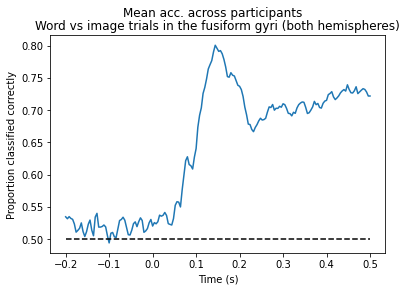

In [339]:
# plot
plot_classfication(
    epochs_list[0].times, 
    fusiform_both_all_participants.iloc[:,6],
    #mean_scores_fu_both,
    fig_name = "fusiform_both_",
    title = "Word vs image trials in the fusiform gyri (both hemispheres)", 
    #subtitle = "Participant %s" % (par_no),
    subtitle = 'Mean acc. across participants',
    save_fig = True)


### Add mean column to dataframe

In [332]:
# Create mean column in big DF
fusiform_both_all_participants['mean'] = fusiform_both_all_participants.mean(axis = 1)
print(fusiform_both_all_participants)

       par_85    par_86    par_87    par_88    par_89    par_95      mean
0    0.519444  0.515278  0.572222  0.531944  0.525000  0.543056  0.534491
1    0.494444  0.527778  0.558333  0.519444  0.523611  0.565278  0.531481
2    0.502778  0.540278  0.568056  0.497222  0.512500  0.587500  0.534722
3    0.486111  0.545833  0.523611  0.540278  0.527778  0.568056  0.531944
4    0.522222  0.558333  0.544444  0.552778  0.487500  0.518056  0.530556
..        ...       ...       ...       ...       ...       ...       ...
171  0.659722  0.723611  0.784722  0.787500  0.747222  0.695833  0.733102
172  0.663889  0.713889  0.787500  0.772222  0.750000  0.704167  0.731944
173  0.661111  0.693056  0.791667  0.763889  0.744444  0.713889  0.728009
174  0.641667  0.709722  0.777778  0.750000  0.745833  0.705556  0.721759
175  0.637500  0.727778  0.781944  0.758333  0.747222  0.677778  0.721759

[176 rows x 7 columns]


In [333]:
# save to csv
fusiform_both_all_participants.to_csv("fusiform_both_all_participants.csv", index = False)

In [366]:
# read the csv and check that it is saved
test = pd.read_csv("/work/SigridAgersnapBomNielsen#1365/MEG_data_analysis/BA45_all_participants.csv")
test

,par_85,par_86,par_87,par_88,par_89,par_95,mean
0,0.495833,0.513889,0.513889,0.508333,0.486111,0.550000,0.511343
1,0.531944,0.504167,0.504167,0.481944,0.544444,0.565278,0.521991
2,0.540278,0.541667,0.541667,0.520833,0.565278,0.581944,0.548611
3,0.522222,0.533333,0.533333,0.529167,0.562500,0.562500,0.540509
4,0.512500,0.522222,0.522222,0.529167,0.559722,0.563889,0.534954
...,...,...,...,...,...,...,...
171,0.594444,0.637500,0.637500,0.590278,0.588889,0.593056,0.606944
172,0.590278,0.612500,0.612500,0.595833,0.595833,0.586111,0.598843
173,0.576389,0.588889,0.588889,0.626389,0.568056,0.586111,0.589120
174,0.565278,0.595833,0.595833,0.638889,0.548611,0.593056,0.589583


In [368]:
mean = test["mean"].mean()

In [369]:
mean

0.5583964646464646

In [370]:
round(mean, 2)

0.56

In [ ]:
# getting mean without before the stimulus is shown- don't know if needed

Then, plot again.

#### Trying to get a mean for baseline and for after showing the stim

In [371]:
BA45_par86 = pd.read_csv("/work/SigridAgersnapBomNielsen#1365/MEG_data_analysis/mean_scores/mean_scores_BA45_lh_86.csv")


In [372]:
BA45_par86

,par_86
0,0.513889
1,0.504167
2,0.541667
3,0.533333
4,0.522222
...,...
171,0.637500
172,0.612500
173,0.588889
174,0.595833


We have 176 measurements. Now we need to figure out how many measurements we have before and after the onset of the stim.

In [389]:
epochs_list[0].baseline

(-0.2, 0.0)

make a list which states whether the timestamp is more than or equal to zero

In [401]:
test_include = epochs_list[0].times >= 0

In [402]:
test_include

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

count the number of true values

In [403]:
np.count_nonzero(test_include)

126

126 measurements after stim onset. which leaves us with:

In [404]:
176-126

50

50 measurements before stim onset. now to calculate the mean before and after stim onset

In [405]:
BA = pd.read_csv("/work/SigridAgersnapBomNielsen#1365/MEG_data_analysis/BA45_all_participants.csv")
fus = pd.read_csv("/work/SigridAgersnapBomNielsen#1365/MEG_data_analysis/fusiform_both_all_participants.csv")

select the first 50 rows to calculate a mean before stim onset

In [408]:
BA_50 = BA.head(50)
BA_mean_before_stim = BA_50["mean"].mean()
round(BA_mean_before_stim, 2)

select the last 126 rows

In [411]:
BA_126 = BA.tail(126)
BA_mean_after_stim = BA_126["mean"].mean()
round(BA_mean_after_stim, 2)

Now the same, but for the fusiform gyri

In [415]:
fus_50 = fus.head(50)
fus_mean_before_stim = fus_50["mean"].mean()
round(fus_mean_before_stim, 2)

0.52

In [416]:
fus_126 = fus.tail(126)
fus_mean_after_stim = fus_126["mean"].mean()
round(fus_mean_after_stim, 2)

0.69

# Permutation test

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import permutation_test_score

In [340]:
# indledende øvelser fra simple class function (need to do it again, because it only functions locally in a function)
X = X_fusiform_both.copy()
#print(X.shape)

n_samples = X.shape[2]

#standardizing the X
sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    
for sample_index in range(n_samples):
    this_X = X[:, :, sample_index]
    sc.fit(this_X)
    this_X_std = sc.transform(this_X)

# calculating the permutation test score
score, permutation_scores, pvalue = permutation_test_score(
    LogisticRegression(penalty="l2", C=1e-3, solver='newton-cg'),
    this_X_std, collapsed_y, cv=StratifiedKFold(), n_permutations=1000, 
    n_jobs=1, random_state=0, verbose=0, scoring=None)
print("Classification Accuracy: %s (pvalue : %s)" % (score, pvalue))

Classification Accuracy: 0.6777777777777778 (pvalue : 0.000999000999000999)


In [341]:
# checking
print(score)
print(pvalue)
print(par_no)

0.6777777777777778
0.000999000999000999
95


In [ ]:
# create a pd dataframe which saves participant number, classification accuracy score and p-value
# ONLY RUN THIS THE FIRST TIME
# df_perm = pd.DataFrame({'participant' : [par_no],
#                     'class_acc': [score],
#                     'permutation_p_val': [pvalue]})
# print(df_perm)

In [342]:
# append new values to df
temp = pd.DataFrame({'participant' : [par_no],
                    'class_acc': [score],
                    'permutation_p_val': [pvalue]})

df_perm = df_perm.append(temp, ignore_index=True)
print(df_perm)

   participant  class_acc  permutation_p_val
0           85   0.637500           0.000999
1           86   0.727778           0.000999
2           87   0.781944           0.000999
3           88   0.758333           0.000999
4           89   0.747222           0.000999
5           95   0.677778           0.000999


/tmp/ipykernel_381/1048796819.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_perm = df_perm.append(temp, ignore_index=True)


In [343]:
# save df
df_perm.to_csv("mean_scores/df_perm_fusiform.csv", index = False)

In [344]:
# testing - it works
test = pd.read_csv("mean_scores/df_perm_fusiform.csv")
print(test)

   participant  class_acc  permutation_p_val
0           85   0.637500           0.000999
1           86   0.727778           0.000999
2           87   0.781944           0.000999
3           88   0.758333           0.000999
4           89   0.747222           0.000999
5           95   0.677778           0.000999


df = pd.DataFrame({'points': [10, 12, 12, 14, 13, 18],
                   'rebounds': [7, 7, 8, 13, 7, 4],
                   'assists': [11, 8, 10, 6, 6, 5]})

### Save X_std and collapsed y per participant

In [345]:
# save X_std ######### 
np.savetxt("preprocessed_data/X_fusiform_both_std_%s.csv" % (par_no), this_X_std, delimiter=",")

In [175]:
# save y_collapsed ###### 
#np.savetxt("preprocessed_data/collapsed_y%s.csv" % (par_no), collapsed_y, delimiter = ",")

In [138]:
#testing that it works - it does
from numpy import genfromtxt

test = genfromtxt('preprocessed_data/collapsed_y_85.csv', delimiter=',')
print(test.shape)

(720,)


### Permutation plot

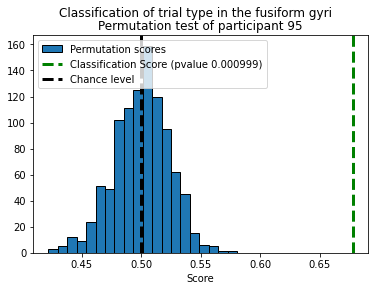

In [346]:
#How many classes
n_classes = np.unique(collapsed_y).size

# round p val
pvalue = round(pvalue,7)

plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance level')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.title("Permutation test of participant %s" % (par_no))
plt.suptitle("Classification of trial type in the fusiform gyri")
savefig_here = "figures/fusiform_both_%s_permutation.png" % (par_no)
plt.savefig(savefig_here)

plt.show()